In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
from models_package.models import Teacher, Student
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# new libraries
from data.data_loader import load_cifar10, load_cifar100, load_imagenet
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck
from torchvision.models.resnet import ResNet18_Weights, ResNet34_Weights
from utils.loss_functions import tkd_kdloss

In [44]:
def compare_model_size(teacher, student):
    teacher_params = sum(p.numel() for p in teacher.parameters())
    student_params = sum(p.numel() for p in student.parameters())
    return teacher_params, student_params

def compare_inference_time(teacher, student, dataloader):
    inputs, _ = next(iter(dataloader))
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    teacher = teacher.to(device)
    student = student.to(device)
    inputs = inputs.to(device)
    
    start_time = time.time()
    with torch.no_grad():
        teacher_outputs = teacher(inputs)
    teacher_time = time.time() - start_time

    start_time = time.time()
    with torch.no_grad():
        student_outputs = student(inputs)
    student_time = time.time() - start_time
    
    return teacher_time, student_time

def compare_performance_metrics(teacher, student, dataloader):
    teacher.eval()
    student.eval()
    
    all_labels = []
    all_teacher_preds = []
    all_student_preds = []

    for inputs, labels in dataloader:
        with torch.no_grad():
            teacher_outputs = teacher(inputs.to(device))
            student_outputs = student(inputs.to(device))
        all_labels.append(labels.cpu().numpy())
        all_teacher_preds.append(torch.argmax(teacher_outputs, dim=1).cpu().numpy())
        all_student_preds.append(torch.argmax(student_outputs, dim=1).cpu().numpy())

    all_labels = np.concatenate(all_labels)
    all_teacher_preds = np.concatenate(all_teacher_preds)
    all_student_preds = np.concatenate(all_student_preds)
    
    metrics = {
        'accuracy': (accuracy_score(all_labels, all_teacher_preds), accuracy_score(all_labels, all_student_preds)),
        'precision': (precision_score(all_labels, all_teacher_preds, average='weighted', zero_division=0), precision_score(all_labels, all_student_preds, average='weighted', zero_division=0)),  # Updated line
        'recall': (recall_score(all_labels, all_teacher_preds, average='weighted'), recall_score(all_labels, all_student_preds, average='weighted')),
        'f1': (f1_score(all_labels, all_teacher_preds, average='weighted'), f1_score(all_labels, all_student_preds, average='weighted'))
    }

    return metrics

def plot_comparison(labels, teacher_values, student_values, title, ylabel):
    # Convert parameter count to millions
    if 'Parameter Count' in title or 'Parameter Count' in ylabel:
        teacher_values = [value / 1e6 for value in teacher_values]
        student_values = [value / 1e6 for value in student_values]

    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots()
    rects1 = ax.bar(x - width/2, teacher_values, width, label='Teacher')
    rects2 = ax.bar(x + width/2, student_values, width, label='Student')

    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend()

    fig.tight_layout()

    plt.show()

In [45]:
# Hyperparameters
learning_rate = 0.001
num_epochs = 25
num_workers = 2
batch_size = 32
temperature = 4.0
alpha = 0.9
momentum = 0.9
num_classes = 100
step_size = 30
gamma = 0.1

# new parameters
# lr_input = 0.1
# momentum_input = 0.9
weight_decay_input = 5e-4
# epochs = 20
# T = 4.0 # temperatureture
# alpha = 0.9
patience = 5  # for early stopping


In [46]:
# Load CIFAR-100 dataset
trainloader, testloader  = load_cifar100()

Files already downloaded and verified
Files already downloaded and verified


In [47]:
# Instantiate the models
###################### Testing 1 ######################
# Create instances of your models
teacher_model = torchvision.models.resnet34(weights=ResNet34_Weights.IMAGENET1K_V1).cuda()
teacher_model.eval()  # Set teacher model to evaluation mode
student_model = torchvision.models.resnet18(weights=None).cuda()

In [39]:
# Instantiate the models
###################### Testing 2 ######################
# Create instances of your models
teacher_model = Teacher()
teacher_model.eval()  # Set teacher model to evaluation mode
student_model = Student()

In [48]:
# Optimizer and scheduler for the student model
optimizer = optim.SGD(student_model.parameters(), lr=learning_rate, momentum=momentum)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

# Optimizer and scheduler for the teacher model
teacher_optimizer = optim.SGD(teacher_model.parameters(), lr=learning_rate, momentum=momentum)
teacher_scheduler = torch.optim.lr_scheduler.StepLR(teacher_optimizer, step_size=step_size, gamma=gamma)

criterion = nn.CrossEntropyLoss()

# # Knowledge Distillation loss function
# def knowledge_distillation_loss(student_outputs, teacher_outputs, temperature):
#     kd_loss = F.kl_div(
#         F.log_softmax(student_outputs / temperature, dim=1),
#         F.softmax(teacher_outputs / temperature, dim=1),
#         reduction='batchmean'
#     ) * (temperature * temperature)
#     return kd_loss

# Function to train the teacher model
def train_teacher(model, trainloader, criterion, optimizer, scheduler, device, num_epochs=5):
    model.train()
    model.to(device)
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:  # Print every 100 mini-batches
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0
        scheduler.step()
    print("Finished Training Teacher")

# Function to train the student model with knowledge distillation
def train_student_with_distillation(student, teacher, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs):
    student.train()
    teacher.eval()
    student.to(device)
    teacher.to(device)
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(tqdm(trainloader)):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            student_outputs = student(inputs)
            with torch.no_grad():
                teacher_outputs = teacher(inputs)
            ce_loss = criterion(student_outputs, labels)
            # kd_loss = knowledge_distillation_loss(student_outputs, teacher_outputs, temperature)
            kd_loss =  tkd_kdloss(student_outputs, teacher_outputs, temperature=temperature) # from utils.loss_functions
            loss = alpha * kd_loss + (1 - alpha) * ce_loss
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 100 == 99:
                print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 100:.3f}")
                running_loss = 0.0
        scheduler.step()
    print("Finished Training Student")

# Assuming the device is a CUDA device if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Call the function to train the teacher model
train_teacher(teacher_model, trainloader, criterion, teacher_optimizer, teacher_scheduler, device, num_epochs=num_epochs)

# Call the function to train the student model with knowledge distillation
train_student_with_distillation(student_model, teacher_model, trainloader, criterion, optimizer, scheduler, device, alpha, temperature, num_epochs=num_epochs)


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:42,  2.41it/s]

[1, 100] loss: 6.184


 26%|████████████████████████████▍                                                                                  | 200/782 [01:22<04:01,  2.41it/s]

[1, 200] loss: 3.639


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:04<03:20,  2.41it/s]

[1, 300] loss: 2.685


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:45<02:38,  2.40it/s]

[1, 400] loss: 2.151


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:27<01:58,  2.39it/s]

[1, 500] loss: 1.787


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:09<01:17,  2.36it/s]

[1, 600] loss: 1.548


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:52<00:34,  2.37it/s]

[1, 700] loss: 1.407


 13%|██████████████▏                                                                                                | 100/782 [00:43<04:55,  2.31it/s]

[2, 100] loss: 1.026


 26%|████████████████████████████▍                                                                                  | 200/782 [01:26<04:13,  2.29it/s]

[2, 200] loss: 0.980


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:10<03:32,  2.27it/s]

[2, 300] loss: 0.969


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:54<02:48,  2.27it/s]

[2, 400] loss: 0.892


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:38<02:04,  2.26it/s]

[2, 500] loss: 0.901


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:23<01:21,  2.24it/s]

[2, 600] loss: 0.880


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [05:08<00:36,  2.23it/s]

[2, 700] loss: 0.857


 13%|██████████████▏                                                                                                | 100/782 [00:44<05:01,  2.26it/s]

[3, 100] loss: 0.563


 26%|████████████████████████████▍                                                                                  | 200/782 [01:28<04:08,  2.35it/s]

[3, 200] loss: 0.560


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:10<03:20,  2.40it/s]

[3, 300] loss: 0.540


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:51<02:38,  2.41it/s]

[3, 400] loss: 0.505


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:33<01:57,  2.40it/s]

[3, 500] loss: 0.562


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:14<01:15,  2.41it/s]

[3, 600] loss: 0.543


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:56<00:34,  2.39it/s]

[3, 700] loss: 0.535


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:49,  2.35it/s]

[4, 100] loss: 0.319


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:09,  2.33it/s]

[4, 200] loss: 0.307


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:08<03:29,  2.30it/s]

[4, 300] loss: 0.306


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:51<02:47,  2.28it/s]

[4, 400] loss: 0.327


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:36<02:05,  2.25it/s]

[4, 500] loss: 0.322


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:20<01:21,  2.23it/s]

[4, 600] loss: 0.339


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [05:05<00:36,  2.26it/s]

[4, 700] loss: 0.349


 13%|██████████████▏                                                                                                | 100/782 [00:43<04:49,  2.36it/s]

[5, 100] loss: 0.197


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:04,  2.38it/s]

[5, 200] loss: 0.175


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:20,  2.41it/s]

[5, 300] loss: 0.189


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:49<02:38,  2.41it/s]

[5, 400] loss: 0.174


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:30<01:57,  2.40it/s]

[5, 500] loss: 0.188


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:12<01:16,  2.39it/s]

[5, 600] loss: 0.178


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:54<00:34,  2.37it/s]

[5, 700] loss: 0.190


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:53,  2.32it/s]

[6, 100] loss: 0.103


 26%|████████████████████████████▍                                                                                  | 200/782 [01:26<04:14,  2.29it/s]

[6, 200] loss: 0.096


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:10<03:32,  2.27it/s]

[6, 300] loss: 0.099


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:54<02:48,  2.27it/s]

[6, 400] loss: 0.101


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:38<02:06,  2.22it/s]

[6, 500] loss: 0.098


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:23<01:21,  2.23it/s]

[6, 600] loss: 0.097


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [05:07<00:36,  2.27it/s]

[6, 700] loss: 0.103


 13%|██████████████▏                                                                                                | 100/782 [00:44<05:03,  2.25it/s]

[7, 100] loss: 0.059


 26%|████████████████████████████▍                                                                                  | 200/782 [01:28<04:19,  2.24it/s]

[7, 200] loss: 0.051


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:13<03:32,  2.26it/s]

[7, 300] loss: 0.054


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:57<02:50,  2.24it/s]

[7, 400] loss: 0.053


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:42<02:04,  2.26it/s]

[7, 500] loss: 0.059


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:26<01:18,  2.33it/s]

[7, 600] loss: 0.056


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [05:08<00:34,  2.38it/s]

[7, 700] loss: 0.061


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:43,  2.40it/s]

[8, 100] loss: 0.037


 26%|████████████████████████████▍                                                                                  | 200/782 [01:23<04:03,  2.39it/s]

[8, 200] loss: 0.033


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:04<03:21,  2.39it/s]

[8, 300] loss: 0.035


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:46<02:40,  2.38it/s]

[8, 400] loss: 0.034


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:29<01:59,  2.35it/s]

[8, 500] loss: 0.034


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:11<01:18,  2.33it/s]

[8, 600] loss: 0.037


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:55<00:35,  2.29it/s]

[8, 700] loss: 0.033


 13%|██████████████▏                                                                                                | 100/782 [00:44<05:00,  2.27it/s]

[9, 100] loss: 0.028


 26%|████████████████████████████▍                                                                                  | 200/782 [01:27<04:05,  2.37it/s]

[9, 200] loss: 0.025


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:09<03:21,  2.40it/s]

[9, 300] loss: 0.023


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:50<02:38,  2.40it/s]

[9, 400] loss: 0.023


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:32<01:57,  2.40it/s]

[9, 500] loss: 0.024


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:14<01:15,  2.40it/s]

[9, 600] loss: 0.025


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:55<00:34,  2.38it/s]

[9, 700] loss: 0.026


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:51,  2.34it/s]

[10, 100] loss: 0.016


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:11,  2.32it/s]

[10, 200] loss: 0.017


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:08<03:30,  2.29it/s]

[10, 300] loss: 0.016


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:52<02:48,  2.27it/s]

[10, 400] loss: 0.017


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:36<02:05,  2.25it/s]

[10, 500] loss: 0.016


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:21<01:21,  2.24it/s]

[10, 600] loss: 0.017


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [05:06<00:36,  2.26it/s]

[10, 700] loss: 0.018


 13%|██████████████▏                                                                                                | 100/782 [00:44<05:04,  2.24it/s]

[11, 100] loss: 0.013


 26%|████████████████████████████▍                                                                                  | 200/782 [01:29<04:17,  2.26it/s]

[11, 200] loss: 0.013


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:13<03:33,  2.26it/s]

[11, 300] loss: 0.014


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:57<02:50,  2.24it/s]

[11, 400] loss: 0.013


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:42<02:05,  2.25it/s]

[11, 500] loss: 0.014


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:26<01:20,  2.27it/s]

[11, 600] loss: 0.013


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [05:10<00:36,  2.26it/s]

[11, 700] loss: 0.012


 13%|██████████████▏                                                                                                | 100/782 [00:44<05:05,  2.23it/s]

[12, 100] loss: 0.012


 26%|████████████████████████████▍                                                                                  | 200/782 [01:29<04:18,  2.25it/s]

[12, 200] loss: 0.010


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:13<03:33,  2.26it/s]

[12, 300] loss: 0.011


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:57<02:48,  2.27it/s]

[12, 400] loss: 0.011


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:42<02:06,  2.23it/s]

[12, 500] loss: 0.011


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:26<01:20,  2.27it/s]

[12, 600] loss: 0.011


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [05:10<00:36,  2.25it/s]

[12, 700] loss: 0.010


 13%|██████████████▏                                                                                                | 100/782 [00:44<05:04,  2.24it/s]

[13, 100] loss: 0.011


 26%|████████████████████████████▍                                                                                  | 200/782 [01:29<04:19,  2.24it/s]

[13, 200] loss: 0.009


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:13<03:34,  2.24it/s]

[13, 300] loss: 0.009


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:58<02:50,  2.24it/s]

[13, 400] loss: 0.009


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:43<02:05,  2.24it/s]

[13, 500] loss: 0.009


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:27<01:21,  2.24it/s]

[13, 600] loss: 0.010


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [05:12<00:36,  2.24it/s]

[13, 700] loss: 0.010


 13%|██████████████▏                                                                                                | 100/782 [00:44<05:04,  2.24it/s]

[14, 100] loss: 0.007


 26%|████████████████████████████▍                                                                                  | 200/782 [01:29<04:19,  2.24it/s]

[14, 200] loss: 0.008


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:14<03:35,  2.24it/s]

[14, 300] loss: 0.009


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:58<02:51,  2.23it/s]

[14, 400] loss: 0.008


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:43<02:05,  2.25it/s]

[14, 500] loss: 0.009


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:27<01:20,  2.25it/s]

[14, 600] loss: 0.010


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [05:12<00:36,  2.23it/s]

[14, 700] loss: 0.008


 13%|██████████████▏                                                                                                | 100/782 [00:44<05:01,  2.26it/s]

[15, 100] loss: 0.007


 26%|████████████████████████████▍                                                                                  | 200/782 [01:28<04:17,  2.26it/s]

[15, 200] loss: 0.007


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:11<03:23,  2.36it/s]

[15, 300] loss: 0.006


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:53<02:39,  2.40it/s]

[15, 400] loss: 0.008


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:35<01:57,  2.41it/s]

[15, 500] loss: 0.007


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:16<01:15,  2.41it/s]

[15, 600] loss: 0.007


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:58<00:34,  2.41it/s]

[15, 700] loss: 0.007


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:43,  2.41it/s]

[16, 100] loss: 0.007


 26%|████████████████████████████▍                                                                                  | 200/782 [01:23<04:01,  2.41it/s]

[16, 200] loss: 0.006


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:04<03:20,  2.40it/s]

[16, 300] loss: 0.005


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:46<02:40,  2.38it/s]

[16, 400] loss: 0.006


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:28<01:59,  2.36it/s]

[16, 500] loss: 0.006


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:11<01:18,  2.33it/s]

[16, 600] loss: 0.007


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:54<00:35,  2.32it/s]

[16, 700] loss: 0.008


 13%|██████████████▏                                                                                                | 100/782 [00:43<05:00,  2.27it/s]

[17, 100] loss: 0.006


 26%|████████████████████████████▍                                                                                  | 200/782 [01:26<04:03,  2.39it/s]

[17, 200] loss: 0.005


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:07<03:20,  2.40it/s]

[17, 300] loss: 0.006


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:49<02:38,  2.41it/s]

[17, 400] loss: 0.005


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:31<01:57,  2.40it/s]

[17, 500] loss: 0.006


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:12<01:16,  2.39it/s]

[17, 600] loss: 0.005


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:54<00:34,  2.38it/s]

[17, 700] loss: 0.006


 13%|██████████████▏                                                                                                | 100/782 [00:42<04:51,  2.34it/s]

[18, 100] loss: 0.005


 26%|████████████████████████████▍                                                                                  | 200/782 [01:25<04:10,  2.32it/s]

[18, 200] loss: 0.006


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:08<03:30,  2.29it/s]

[18, 300] loss: 0.005


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:52<02:48,  2.27it/s]

[18, 400] loss: 0.006


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:36<02:05,  2.25it/s]

[18, 500] loss: 0.005


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:21<01:21,  2.23it/s]

[18, 600] loss: 0.005


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [05:05<00:36,  2.27it/s]

[18, 700] loss: 0.006


 13%|██████████████▏                                                                                                | 100/782 [00:44<05:04,  2.24it/s]

[19, 100] loss: 0.005


 26%|████████████████████████████▍                                                                                  | 200/782 [01:28<04:15,  2.28it/s]

[19, 200] loss: 0.005


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:13<03:34,  2.25it/s]

[19, 300] loss: 0.004


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:57<02:50,  2.24it/s]

[19, 400] loss: 0.005


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:42<02:05,  2.25it/s]

[19, 500] loss: 0.005


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:26<01:21,  2.23it/s]

[19, 600] loss: 0.006


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [05:11<00:36,  2.25it/s]

[19, 700] loss: 0.005


 13%|██████████████▏                                                                                                | 100/782 [00:44<05:03,  2.25it/s]

[20, 100] loss: 0.006


 26%|████████████████████████████▍                                                                                  | 200/782 [01:29<04:19,  2.24it/s]

[20, 200] loss: 0.006


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:13<03:34,  2.25it/s]

[20, 300] loss: 0.005


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:58<02:50,  2.25it/s]

[20, 400] loss: 0.005


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:42<02:05,  2.24it/s]

[20, 500] loss: 0.006


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:27<01:20,  2.25it/s]

[20, 600] loss: 0.005


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [05:12<00:36,  2.25it/s]

[20, 700] loss: 0.005


 13%|██████████████▏                                                                                                | 100/782 [00:44<05:04,  2.24it/s]

[21, 100] loss: 0.004


 26%|████████████████████████████▍                                                                                  | 200/782 [01:29<04:18,  2.25it/s]

[21, 200] loss: 0.004


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:13<03:33,  2.26it/s]

[21, 300] loss: 0.004


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:57<02:49,  2.25it/s]

[21, 400] loss: 0.004


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:42<02:04,  2.26it/s]

[21, 500] loss: 0.006


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:26<01:18,  2.33it/s]

[21, 600] loss: 0.005


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [05:08<00:34,  2.40it/s]

[21, 700] loss: 0.004


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:43,  2.41it/s]

[22, 100] loss: 0.004


 26%|████████████████████████████▍                                                                                  | 200/782 [01:23<04:01,  2.41it/s]

[22, 200] loss: 0.004


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:04<03:20,  2.40it/s]

[22, 300] loss: 0.004


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:46<02:40,  2.38it/s]

[22, 400] loss: 0.004


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:29<01:59,  2.36it/s]

[22, 500] loss: 0.004


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:11<01:18,  2.33it/s]

[22, 600] loss: 0.004


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:54<00:35,  2.31it/s]

[22, 700] loss: 0.004


 13%|██████████████▏                                                                                                | 100/782 [00:44<05:01,  2.26it/s]

[23, 100] loss: 0.003


 26%|████████████████████████████▍                                                                                  | 200/782 [01:28<04:19,  2.25it/s]

[23, 200] loss: 0.004


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:13<03:33,  2.26it/s]

[23, 300] loss: 0.003


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:57<02:48,  2.27it/s]

[23, 400] loss: 0.004


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:41<02:05,  2.24it/s]

[23, 500] loss: 0.004


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:26<01:21,  2.24it/s]

[23, 600] loss: 0.004


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [05:11<00:36,  2.24it/s]

[23, 700] loss: 0.005


 13%|██████████████▏                                                                                                | 100/782 [00:44<05:05,  2.23it/s]

[24, 100] loss: 0.004


 26%|████████████████████████████▍                                                                                  | 200/782 [01:29<04:19,  2.24it/s]

[24, 200] loss: 0.004


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:13<03:35,  2.24it/s]

[24, 300] loss: 0.004


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:58<02:49,  2.25it/s]

[24, 400] loss: 0.004


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:43<02:05,  2.24it/s]

[24, 500] loss: 0.003


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:27<01:20,  2.25it/s]

[24, 600] loss: 0.003


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [05:12<00:36,  2.25it/s]

[24, 700] loss: 0.003


 13%|██████████████▏                                                                                                | 100/782 [00:44<05:03,  2.24it/s]

[25, 100] loss: 0.004


 26%|████████████████████████████▍                                                                                  | 200/782 [01:28<04:18,  2.25it/s]

[25, 200] loss: 0.004


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:13<03:35,  2.24it/s]

[25, 300] loss: 0.003


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:58<02:50,  2.24it/s]

[25, 400] loss: 0.004


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:42<02:06,  2.23it/s]

[25, 500] loss: 0.004


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:27<01:21,  2.24it/s]

[25, 600] loss: 0.003


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [05:12<00:36,  2.25it/s]

[25, 700] loss: 0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [05:48<00:00,  2.25it/s]


Finished Training Teacher


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:43,  2.41it/s]

[1, 100] loss: 1.553


 26%|████████████████████████████▍                                                                                  | 200/782 [01:23<04:01,  2.41it/s]

[1, 200] loss: 1.462


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:04<03:21,  2.39it/s]

[1, 300] loss: 1.388


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:46<02:39,  2.40it/s]

[1, 400] loss: 1.322


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:27<01:56,  2.43it/s]

[1, 500] loss: 1.255


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:09<01:16,  2.39it/s]

[1, 600] loss: 1.202


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:49<00:32,  2.54it/s]

[1, 700] loss: 1.179


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:25,  2.57it/s]

[2, 100] loss: 1.121


 26%|████████████████████████████▍                                                                                  | 200/782 [01:17<03:46,  2.58it/s]

[2, 200] loss: 1.088


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:56<03:08,  2.56it/s]

[2, 300] loss: 1.069


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:35<02:29,  2.56it/s]

[2, 400] loss: 1.049


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:15<01:51,  2.54it/s]

[2, 500] loss: 1.038


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:54<01:12,  2.51it/s]

[2, 600] loss: 1.018


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:34<00:33,  2.48it/s]

[2, 700] loss: 1.015


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:40,  2.43it/s]

[3, 100] loss: 0.989


 26%|████████████████████████████▍                                                                                  | 200/782 [01:22<04:01,  2.41it/s]

[3, 200] loss: 0.975


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:03<03:20,  2.40it/s]

[3, 300] loss: 0.981


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:43<02:29,  2.55it/s]

[3, 400] loss: 0.973


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:22<01:49,  2.57it/s]

[3, 500] loss: 0.969


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:01<01:10,  2.57it/s]

[3, 600] loss: 0.958


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:40<00:31,  2.57it/s]

[3, 700] loss: 0.958


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:26,  2.56it/s]

[4, 100] loss: 0.941


 26%|████████████████████████████▍                                                                                  | 200/782 [01:18<03:49,  2.54it/s]

[4, 200] loss: 0.942


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:57<03:11,  2.52it/s]

[4, 300] loss: 0.931


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:37<02:33,  2.49it/s]

[4, 400] loss: 0.950


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:18<01:54,  2.47it/s]

[4, 500] loss: 0.945


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:59<01:14,  2.43it/s]

[4, 600] loss: 0.935


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:40<00:33,  2.42it/s]

[4, 700] loss: 0.933


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:44,  2.40it/s]

[5, 100] loss: 0.924


 26%|████████████████████████████▍                                                                                  | 200/782 [01:23<03:59,  2.43it/s]

[5, 200] loss: 0.924


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:04<03:21,  2.39it/s]

[5, 300] loss: 0.918


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:46<02:38,  2.41it/s]

[5, 400] loss: 0.922


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:27<01:56,  2.41it/s]

[5, 500] loss: 0.931


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:09<01:16,  2.37it/s]

[5, 600] loss: 0.915


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:51<00:34,  2.40it/s]

[5, 700] loss: 0.907


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:45,  2.39it/s]

[6, 100] loss: 0.905


 26%|████████████████████████████▍                                                                                  | 200/782 [01:23<04:03,  2.39it/s]

[6, 200] loss: 0.917


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:05<03:19,  2.41it/s]

[6, 300] loss: 0.909


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:46<02:37,  2.42it/s]

[6, 400] loss: 0.911


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:27<01:57,  2.40it/s]

[6, 500] loss: 0.901


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:09<01:13,  2.48it/s]

[6, 600] loss: 0.902


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:48<00:32,  2.56it/s]

[6, 700] loss: 0.898


 13%|██████████████▏                                                                                                | 100/782 [00:38<04:25,  2.57it/s]

[7, 100] loss: 0.899


 26%|████████████████████████████▍                                                                                  | 200/782 [01:17<03:47,  2.56it/s]

[7, 200] loss: 0.900


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:56<03:08,  2.56it/s]

[7, 300] loss: 0.894


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:35<02:29,  2.55it/s]

[7, 400] loss: 0.896


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:15<01:51,  2.53it/s]

[7, 500] loss: 0.888


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:54<01:12,  2.51it/s]

[7, 600] loss: 0.893


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:34<00:33,  2.48it/s]

[7, 700] loss: 0.895


 13%|██████████████▏                                                                                                | 100/782 [00:40<04:40,  2.43it/s]

[8, 100] loss: 0.886


 26%|████████████████████████████▍                                                                                  | 200/782 [01:22<04:00,  2.42it/s]

[8, 200] loss: 0.887


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:03<03:20,  2.40it/s]

[8, 300] loss: 0.876


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:45<02:40,  2.38it/s]

[8, 400] loss: 0.885


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:27<01:56,  2.42it/s]

[8, 500] loss: 0.888


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:08<01:15,  2.41it/s]

[8, 600] loss: 0.875


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:50<00:34,  2.38it/s]

[8, 700] loss: 0.883


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:42,  2.42it/s]

[9, 100] loss: 0.874


 26%|████████████████████████████▍                                                                                  | 200/782 [01:23<04:04,  2.38it/s]

[9, 200] loss: 0.867


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:04<03:19,  2.42it/s]

[9, 300] loss: 0.880


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:46<02:38,  2.41it/s]

[9, 400] loss: 0.875


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:27<01:58,  2.38it/s]

[9, 500] loss: 0.869


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:09<01:15,  2.41it/s]

[9, 600] loss: 0.865


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:50<00:34,  2.41it/s]

[9, 700] loss: 0.866


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:32,  2.50it/s]

[10, 100] loss: 0.870


 26%|████████████████████████████▍                                                                                  | 200/782 [01:20<03:47,  2.56it/s]

[10, 200] loss: 0.866


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [01:59<03:07,  2.57it/s]

[10, 300] loss: 0.859


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:38<02:28,  2.57it/s]

[10, 400] loss: 0.862


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:17<01:50,  2.56it/s]

[10, 500] loss: 0.864


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:56<01:11,  2.56it/s]

[10, 600] loss: 0.862


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:35<00:32,  2.54it/s]

[10, 700] loss: 0.854


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:32,  2.50it/s]

[11, 100] loss: 0.858


 26%|████████████████████████████▍                                                                                  | 200/782 [01:20<03:55,  2.48it/s]

[11, 200] loss: 0.860


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:00<03:18,  2.43it/s]

[11, 300] loss: 0.848


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:42<02:37,  2.42it/s]

[11, 400] loss: 0.854


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:23<01:57,  2.40it/s]

[11, 500] loss: 0.849


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:05<01:16,  2.39it/s]

[11, 600] loss: 0.843


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:47<00:34,  2.38it/s]

[11, 700] loss: 0.854


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:41,  2.42it/s]

[12, 100] loss: 0.846


 26%|████████████████████████████▍                                                                                  | 200/782 [01:22<04:02,  2.40it/s]

[12, 200] loss: 0.847


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:04<03:21,  2.39it/s]

[12, 300] loss: 0.836


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:46<02:37,  2.42it/s]

[12, 400] loss: 0.845


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:27<01:57,  2.40it/s]

[12, 500] loss: 0.846


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:09<01:16,  2.38it/s]

[12, 600] loss: 0.843


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:51<00:33,  2.43it/s]

[12, 700] loss: 0.834


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:46,  2.38it/s]

[13, 100] loss: 0.835


 26%|████████████████████████████▍                                                                                  | 200/782 [01:23<04:00,  2.42it/s]

[13, 200] loss: 0.847


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:04<03:20,  2.41it/s]

[13, 300] loss: 0.827


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:46<02:40,  2.38it/s]

[13, 400] loss: 0.838


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:28<01:58,  2.39it/s]

[13, 500] loss: 0.835


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:10<01:16,  2.39it/s]

[13, 600] loss: 0.833


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:52<00:34,  2.39it/s]

[13, 700] loss: 0.826


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:45,  2.39it/s]

[14, 100] loss: 0.829


 26%|████████████████████████████▍                                                                                  | 200/782 [01:23<04:01,  2.41it/s]

[14, 200] loss: 0.833


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:04<03:17,  2.44it/s]

[14, 300] loss: 0.823


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:46<02:39,  2.40it/s]

[14, 400] loss: 0.824


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:28<01:58,  2.39it/s]

[14, 500] loss: 0.827


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:09<01:14,  2.43it/s]

[14, 600] loss: 0.824


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:51<00:34,  2.39it/s]

[14, 700] loss: 0.814


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:41,  2.42it/s]

[15, 100] loss: 0.818


 26%|████████████████████████████▍                                                                                  | 200/782 [01:22<04:03,  2.39it/s]

[15, 200] loss: 0.820


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:04<03:19,  2.41it/s]

[15, 300] loss: 0.818


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:46<02:39,  2.40it/s]

[15, 400] loss: 0.822


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:27<01:57,  2.39it/s]

[15, 500] loss: 0.810


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:09<01:15,  2.40it/s]

[15, 600] loss: 0.821


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:51<00:34,  2.40it/s]

[15, 700] loss: 0.805


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:44,  2.40it/s]

[16, 100] loss: 0.811


 26%|████████████████████████████▍                                                                                  | 200/782 [01:23<04:03,  2.39it/s]

[16, 200] loss: 0.809


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:05<03:21,  2.39it/s]

[16, 300] loss: 0.814


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:47<02:39,  2.39it/s]

[16, 400] loss: 0.804


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:28<01:57,  2.40it/s]

[16, 500] loss: 0.806


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:10<01:15,  2.41it/s]

[16, 600] loss: 0.809


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:52<00:34,  2.40it/s]

[16, 700] loss: 0.803


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:44,  2.40it/s]

[17, 100] loss: 0.798


 26%|████████████████████████████▍                                                                                  | 200/782 [01:23<04:01,  2.41it/s]

[17, 200] loss: 0.795


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:04<03:19,  2.41it/s]

[17, 300] loss: 0.801


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:46<02:38,  2.41it/s]

[17, 400] loss: 0.806


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:27<01:56,  2.41it/s]

[17, 500] loss: 0.807


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:09<01:15,  2.42it/s]

[17, 600] loss: 0.803


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:50<00:33,  2.42it/s]

[17, 700] loss: 0.796


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:43,  2.41it/s]

[18, 100] loss: 0.795


 26%|████████████████████████████▍                                                                                  | 200/782 [01:21<03:47,  2.55it/s]

[18, 200] loss: 0.796


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:00<03:08,  2.56it/s]

[18, 300] loss: 0.793


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:39<02:28,  2.58it/s]

[18, 400] loss: 0.790


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:18<01:50,  2.55it/s]

[18, 500] loss: 0.794


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [03:57<01:11,  2.56it/s]

[18, 600] loss: 0.784


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:36<00:32,  2.55it/s]

[18, 700] loss: 0.788


 13%|██████████████▏                                                                                                | 100/782 [00:39<04:31,  2.51it/s]

[19, 100] loss: 0.779


 26%|████████████████████████████▍                                                                                  | 200/782 [01:19<03:54,  2.48it/s]

[19, 200] loss: 0.797


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:00<03:15,  2.47it/s]

[19, 300] loss: 0.785


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:40<02:37,  2.43it/s]

[19, 400] loss: 0.785


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:21<01:55,  2.44it/s]

[19, 500] loss: 0.783


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:03<01:15,  2.43it/s]

[19, 600] loss: 0.786


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:44<00:33,  2.41it/s]

[19, 700] loss: 0.776


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:48,  2.37it/s]

[20, 100] loss: 0.780


 26%|████████████████████████████▍                                                                                  | 200/782 [01:23<03:59,  2.43it/s]

[20, 200] loss: 0.784


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:04<03:20,  2.40it/s]

[20, 300] loss: 0.776


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:46<02:40,  2.39it/s]

[20, 400] loss: 0.778


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:28<01:56,  2.42it/s]

[20, 500] loss: 0.777


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:09<01:15,  2.40it/s]

[20, 600] loss: 0.778


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:51<00:34,  2.39it/s]

[20, 700] loss: 0.767


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:41,  2.42it/s]

[21, 100] loss: 0.772


 26%|████████████████████████████▍                                                                                  | 200/782 [01:22<04:03,  2.39it/s]

[21, 200] loss: 0.762


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:04<03:21,  2.39it/s]

[21, 300] loss: 0.769


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:46<02:38,  2.40it/s]

[21, 400] loss: 0.768


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:28<01:57,  2.40it/s]

[21, 500] loss: 0.773


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:09<01:16,  2.39it/s]

[21, 600] loss: 0.762


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:51<00:34,  2.40it/s]

[21, 700] loss: 0.772


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:41,  2.42it/s]

[22, 100] loss: 0.762


 26%|████████████████████████████▍                                                                                  | 200/782 [01:22<04:01,  2.41it/s]

[22, 200] loss: 0.753


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:04<03:21,  2.39it/s]

[22, 300] loss: 0.765


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:45<02:37,  2.42it/s]

[22, 400] loss: 0.754


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:27<01:57,  2.40it/s]

[22, 500] loss: 0.762


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:09<01:16,  2.39it/s]

[22, 600] loss: 0.760


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:50<00:33,  2.41it/s]

[22, 700] loss: 0.760


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:46,  2.38it/s]

[23, 100] loss: 0.750


 26%|████████████████████████████▍                                                                                  | 200/782 [01:23<04:03,  2.39it/s]

[23, 200] loss: 0.748


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:05<03:21,  2.39it/s]

[23, 300] loss: 0.759


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:47<02:38,  2.40it/s]

[23, 400] loss: 0.752


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:28<01:58,  2.39it/s]

[23, 500] loss: 0.751


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:10<01:15,  2.41it/s]

[23, 600] loss: 0.743


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:51<00:34,  2.39it/s]

[23, 700] loss: 0.754


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:42,  2.41it/s]

[24, 100] loss: 0.749


 26%|████████████████████████████▍                                                                                  | 200/782 [01:22<04:01,  2.41it/s]

[24, 200] loss: 0.745


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:04<03:20,  2.41it/s]

[24, 300] loss: 0.742


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:45<02:38,  2.40it/s]

[24, 400] loss: 0.743


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:27<01:57,  2.40it/s]

[24, 500] loss: 0.742


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:09<01:15,  2.42it/s]

[24, 600] loss: 0.742


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:50<00:34,  2.40it/s]

[24, 700] loss: 0.736


 13%|██████████████▏                                                                                                | 100/782 [00:41<04:45,  2.39it/s]

[25, 100] loss: 0.730


 26%|████████████████████████████▍                                                                                  | 200/782 [01:23<03:59,  2.43it/s]

[25, 200] loss: 0.735


 38%|██████████████████████████████████████████▌                                                                    | 300/782 [02:04<03:21,  2.39it/s]

[25, 300] loss: 0.739


 51%|████████████████████████████████████████████████████████▊                                                      | 400/782 [02:46<02:40,  2.38it/s]

[25, 400] loss: 0.732


 64%|██████████████████████████████████████████████████████████████████████▉                                        | 500/782 [03:28<01:58,  2.39it/s]

[25, 500] loss: 0.731


 77%|█████████████████████████████████████████████████████████████████████████████████████▏                         | 600/782 [04:10<01:16,  2.39it/s]

[25, 600] loss: 0.734


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████▎           | 700/782 [04:52<00:34,  2.38it/s]

[25, 700] loss: 0.735


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 782/782 [05:26<00:00,  2.39it/s]

Finished Training Student


In [51]:
###################### Testing 1 ######################
# Save the student model weights and architecture
torch.save(student_model.state_dict(), 'student_model_weights_ckd_1.pth')
torch.save(student_model, 'student_model_ckd_1.pth')
print('weights and architecture saved and exported')

weights and architecture saved and exported


In [52]:
###################### Testing 1 ######################
# Save the student model weights and architecture
torch.save(teacher_model.state_dict(), 'teacher_model_weights_ckd_1.pth')
torch.save(teacher_model, 'teacher_model_ckd_1.pth')
print('weights and architecture saved and exported')

weights and architecture saved and exported


In [41]:
###################### Testing 2 ######################
# Save the student model weights and architecture
torch.save(student_model.state_dict(), 'student_model_weights_ckd_2.pth')
torch.save(student_model, 'student_model_ckd_2.pth')
print('weights and architecture saved and exported')

weights and architecture saved and exported


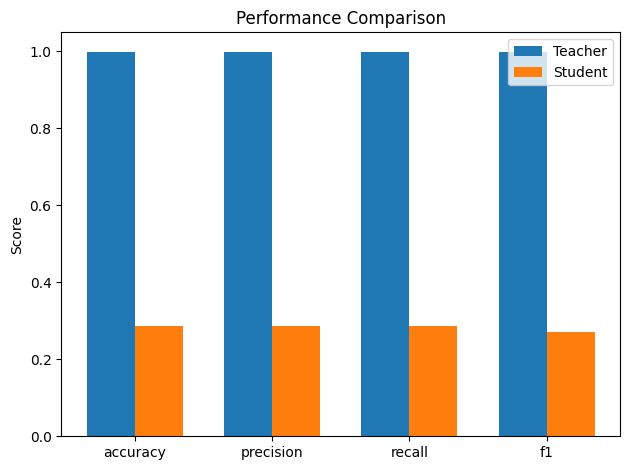

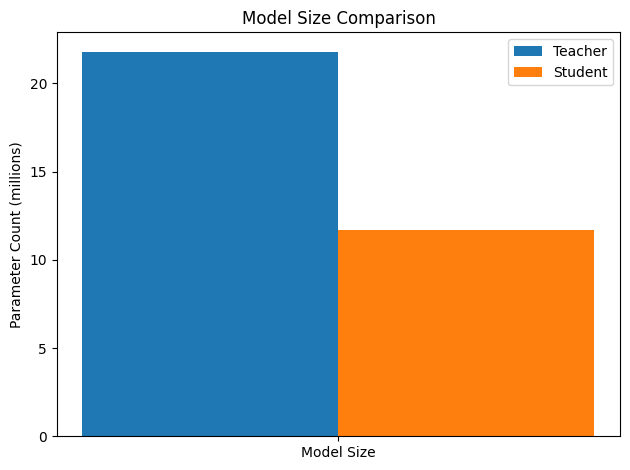

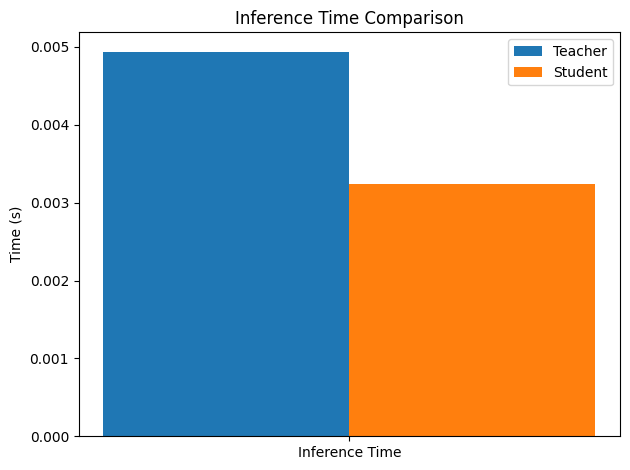

In [50]:
# Call the comparison and plotting functions after training
teacher_params, student_params = compare_model_size(teacher_model, student_model)
teacher_time, student_time = compare_inference_time(teacher_model, student_model, trainloader)
performance_metrics = compare_performance_metrics(teacher_model, student_model, trainloader)

# Extracting the metric values for plotting
performance_labels = ['accuracy', 'precision', 'recall', 'f1']
teacher_performance_values = [performance_metrics[metric][0] for metric in performance_labels]
student_performance_values = [performance_metrics[metric][1] for metric in performance_labels]

# Plotting the comparison for performance metrics
plot_comparison(performance_labels, teacher_performance_values, student_performance_values, 'Performance Comparison', 'Score')

# Plotting the comparison for model size
model_size_labels = ['Model Size']
teacher_model_size_values = [teacher_params]
student_model_size_values = [student_params]
plot_comparison(model_size_labels, teacher_model_size_values, student_model_size_values, 'Model Size Comparison', 'Parameter Count (millions)')

# Plotting the comparison for inference time
inference_time_labels = ['Inference Time']
teacher_inference_time_values = [teacher_time]
student_inference_time_values = [student_time]
plot_comparison(inference_time_labels, teacher_inference_time_values, student_inference_time_values, 'Inference Time Comparison', 'Time (s)')